---
title: Exploratory Data Analysis
---

In [1]:
import pandas as pd
from math import floor
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

In [2]:
sns.set_theme(context = 'paper', style = 'ticks', palette = 'deep', color_codes = True)
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300

### EDA of match_results 

In [3]:
match_results = pd.read_csv('data/match_results.csv', parse_dates=['Date'], dtype = {'HeadCoach' : 'str'})
match_results.head()

,League,Country,Date,Team,Goals,Result,isHome,HeadCoach,DaysInPost
0,Premier League,England,2014-08-16,Manchester Utd,1.0,loss,True,Louis van Gaal,33.0
1,Premier League,England,2014-08-16,Stoke City,0.0,loss,True,Mark Hughes,443.0
2,Premier League,England,2014-08-16,Leicester City,2.0,draw,True,Nigel Pearson,1005.0
3,Premier League,England,2014-08-16,Arsenal,2.0,win,True,Arsène Wenger,6528.0
4,Premier League,England,2014-08-17,Liverpool,2.0,win,True,Brendan Rodgers,777.0


In [4]:
min_season = match_results['Date'].dt.year.min()
max_season = match_results['Date'].dt.year.max()
leagues = ", ".join(match_results['League'].unique())
n_match = floor(len(match_results) / 2)
n_team = match_results['Team'].nunique()
n_team_no_coach = match_results.groupby(['Team'])['HeadCoach'].apply(lambda x: x.isnull().all()).sum()
perc_match_no_coach = match_results['HeadCoach'].isnull().sum() / len(match_results) * 100
n_unique_coach = match_results['HeadCoach'].nunique()
n_unique_coach_records = match_results.groupby(['HeadCoach'])['Team'].nunique().reset_index(name='n_team').sort_values(by='n_team', ascending=False)

We collected matches results and head coach records from Men's Football First Divisions during {eval}`min_season` - {eval}`max_season` seasons for the following leagues : {eval}`n_leagues`.

This amount to a total of {eval}`n_matches` matches across {eval}`n_teams` teams.
Out of these {eval}`n_teams` we don't have any records of head coach for {eval}`n_teams_no_coach` teams.

For certain team information about head coach is present but no throughout the study period. From match results this represent {eval}`perc_match_no_coach`% of the matches.

There is a total of {eval}`n_unique_coach` unique head coaches in the dataset and {eval}`n_unique_coach_records` records of head coach appointments.

In [5]:
#| label: data_summary

match_summary = match_results.groupby(['League', 'Country']).agg(
    {
        'Team' : 'nunique',
        'Date' : 'size',
        'Goals' : 'mean'
    }
)

match_summary['Goals'] = match_summary['Goals'].round(2)
match_summary.columns = ['Number of Teams', 'Number of Matches', 'Average Goals per Match']
match_summary

,,Number of Teams,Number of Matches,Average Goals per Match
League,Country,,,
Bundesliga,Germany,31,5220,1.49
La Liga,Spain,31,6596,1.36
Ligue 1,France,32,6445,1.32
Premier League,England,33,5623,1.26
Serie A,Italy,34,6078,1.36


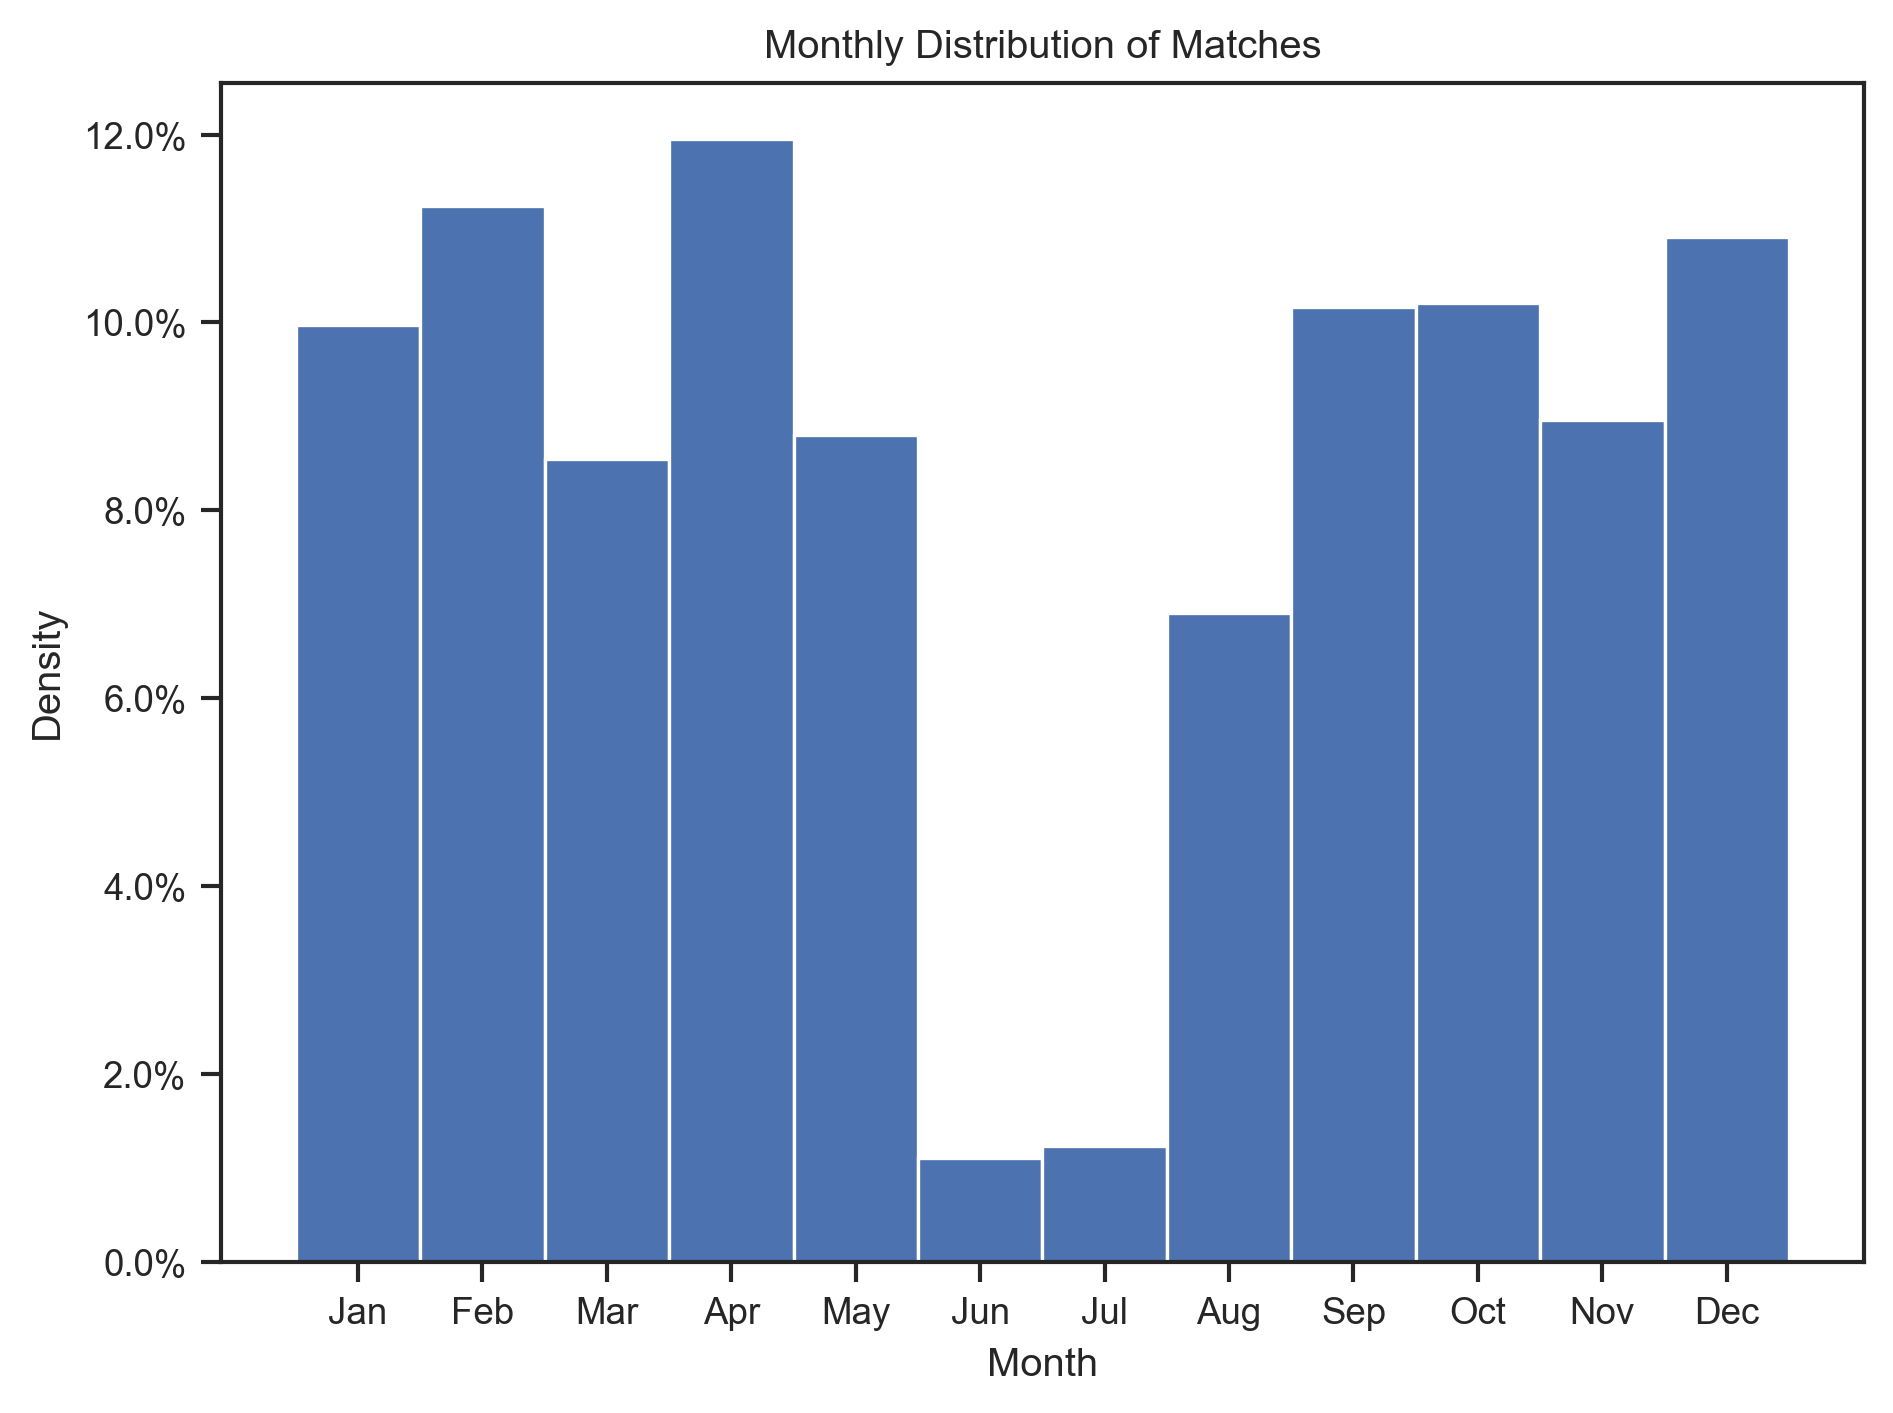

In [6]:
#| label: match_distribution

# Plot distribution of match 
plt.figure()
sns.histplot(match_results['Date'].dt.month, bins=12, stat='density', discrete = True, alpha = 1)
plt.title('Monthly Distribution of Matches')
plt.xlabel('Month')
plt.ylabel('Density')
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
months = pd.date_range('2022-01-01', '2022-12-31', freq='ME').strftime('%b').tolist()
plt.xticks(range(1, 13), months);

In [7]:
home_goal = match_results[match_results['isHome']]['Goals'].mean()
away_goal = match_results[~match_results['isHome']]['Goals'].mean()
diff_goal_perc = ((away_goal - home_goal) / home_goal) * 100

home_win = match_results[match_results['isHome']]['Result'].value_counts(normalize=True)['win']
away_win = match_results[~match_results['isHome']]['Result'].value_counts(normalize=True)['win']
diff_win_perc = ((away_win - home_win) / home_win) * 100
home_draw = match_results[match_results['isHome']]['Result'].value_counts(normalize=True)['draw']

In average, team playing at home scored {eval}`home_goals:.2f` goals while away team scored {away_goals:.2f} goals ({eval}`diff_goal_perc:.0f` % less goals).

This resulted in {eval}`home_win*100:.0f` matches won by team playing at home vs {eval}`away_win*100:.0f` for the team playing away ({eval}`diff_win_perc:.0f` % less wins). Draw matches accounted for {eval}`home_draw:.0f` % of the matches. This effect is called home advantage.

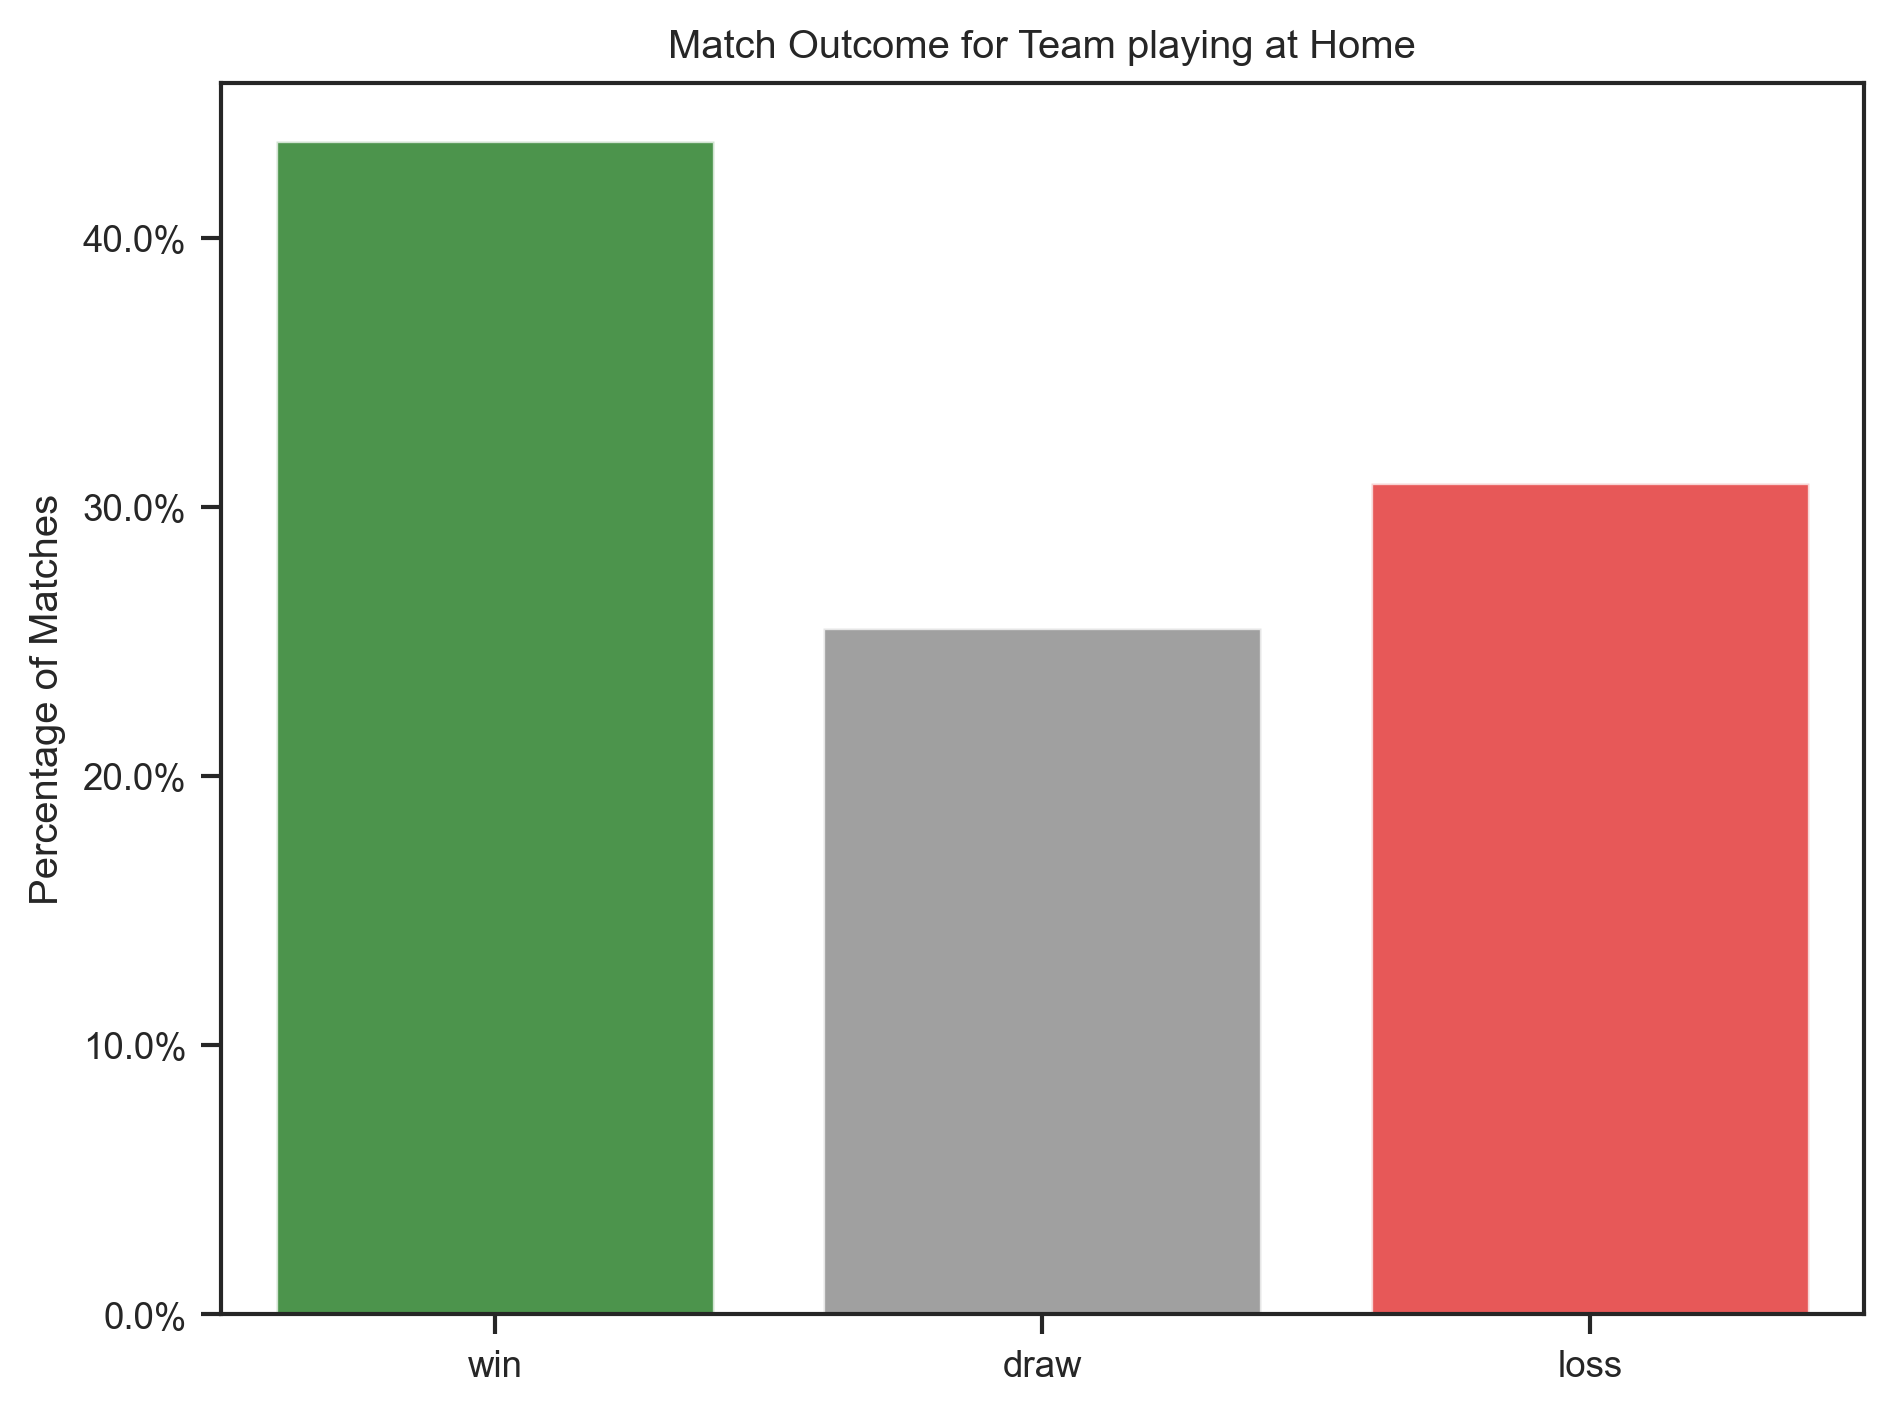

In [9]:
#| label: venue_effect
plt.figure()
sns.countplot(data=match_results[match_results['isHome']], x='Result', hue = "Result",
               order = ['win', 'draw', 'loss'], stat = 'proportion', palette = ['red', 'gray', 'green'], alpha = 0.75)
plt.title('Match Outcome for Team playing at Home')
plt.xlabel('')
plt.ylabel('Percentage of Matches')
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))